In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 1. 실내에서 물체와 사람이 함께 있는 사진으로 사람 분리하기

(320, 320, 3)


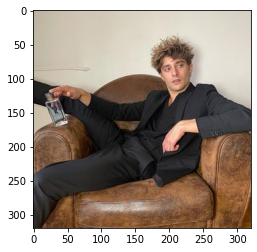

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# PixelLib 제공 모델 다운로드
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fce857b8190>)

In [4]:
# 시그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [9]:
# PASCAL VOC 데이터의 라벨 종류 확인
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

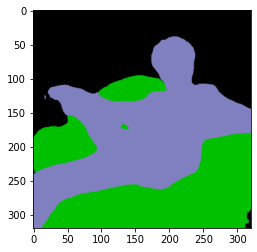

In [6]:
# 모델의 출력값
plt.imshow(output)
plt.show()

In [7]:
segvalues

{'class_ids': array([ 0, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
sofa


In [11]:
# 색상 코드 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
colormap[15]

array([192, 128, 128])

In [13]:
# 색상 추출값 순서 변경
seg_color = (128,128,192)

(320, 320)


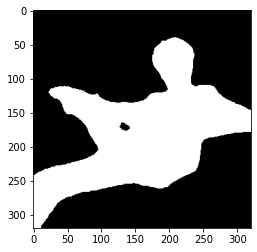

In [14]:
# seg_color로만 이루어진 마스크 생성
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

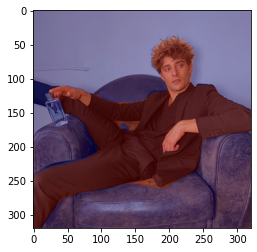

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

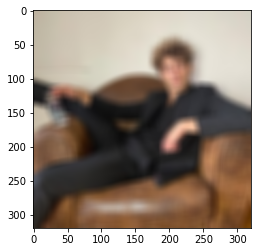

In [16]:
# blur 함수를 이용하여 사진 전체를 흐리게 처리
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

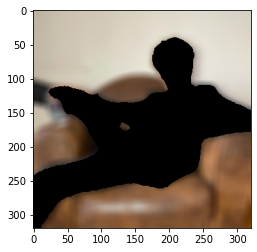

In [17]:
# 흐려진 사진에서 세그멘테이션 마스크를 분리해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()     # 배경은 255, 사람은 0

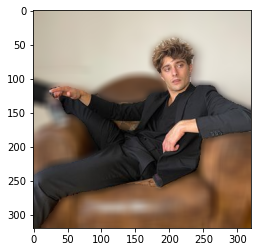

In [18]:
# 배경과 사람 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 최종 결과
* PASCAL VOC 데이터의 라벨 종류를 확인했던 것과 마찬가지로 사진에는 '사람', '소파', '배경'만 존재.
* 심지어, 사람과 소파의 색깔 대비 등 사람이 인식할 수 있는 분명한 구분이 있지만, 소파의 일부분을 사람으로 인식하고, 사람의 일부분을 배경으로 인식하며 배경도 포함되어 사람을 인식하는 문제점을 발견.
* 특히 실내라서 아웃포커싱이 제대로 된 사진이 아니기 때문에 모델이 사람과 물체, 배경을 구분하지 못한 근본적인 문제점.
* 따라서, 실내 사진으로 세그멘테이션 모델을 활용하려면 피사계심도의 아웃포커싱과 얕은 피사계심도 모두 활용해야 함.

## 2. 외부에서 물체와 사람, 배경이 크게 존재하는 사진으로 사람 분리하기

(320, 320, 3)


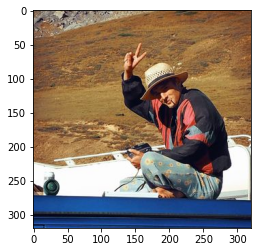

In [19]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

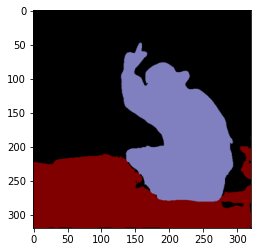

In [21]:
# 모델의 출력값
plt.imshow(output)
plt.show()

In [22]:
segvalues

{'class_ids': array([ 0,  4, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True, False]])}

In [23]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
boat
person


In [24]:
# 색상 코드 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [25]:
colormap[15]

array([192, 128, 128])

In [26]:
# 색상 추출값 순서 변경
seg_color = (128,128,192)

(320, 320)


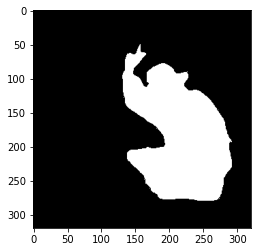

In [27]:
# seg_color로만 이루어진 마스크 생성
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

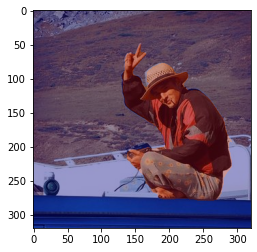

In [28]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

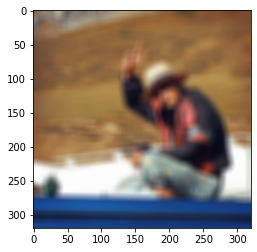

In [29]:
# blur 함수를 이용하여 사진 전체를 흐리게 처리
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

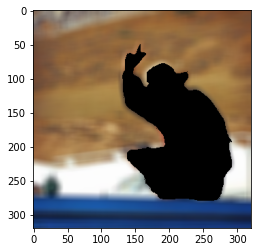

In [30]:
# 흐려진 사진에서 세그멘테이션 마스크를 분리해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()     # 배경은 255, 사람은 0

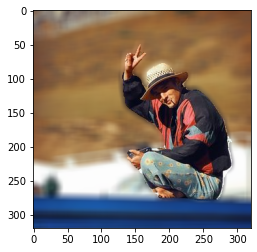

In [31]:
# 배경과 사람 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 최종 결과
* 앞선 실내 사진과는 다르게 모델이 배경/물체와 사람을 좀 더 세밀하게 구분한 것을 알 수 있음.
* 사람의 일부를 또 배경으로 인식하는 것과 사람이 아닌 아주 작은 정도로 사람으로 구분하고 있음
* 하지만, 외부 사진이라 배경이 아웃포커싱이 되지 않았음에도 불구하고 나름 실내 사진에 비해 성공적이라고 볼 수 있음
* 따라서, 아웃포커싱이 제대로 이루어진다면 완전한 사람과 배경/물체 분리가 가능할 수 있다고 생각함. 

## 3. 외부에서 사람의 뒷 모습과 배경만 있는 사진에서 사람 분리하기

(800, 640, 3)


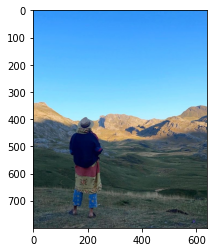

In [32]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

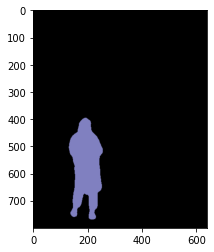

In [34]:
# 모델의 출력값
plt.imshow(output)
plt.show()

In [35]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [36]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [37]:
# 색상 코드 확인
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [38]:
colormap[15]

array([192, 128, 128])

In [39]:
# 색상 추출값 순서 변경
seg_color = (128,128,192)

(800, 640)


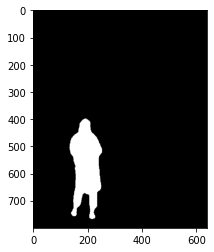

In [40]:
# seg_color로만 이루어진 마스크 생성
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

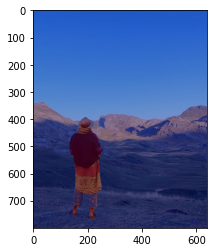

In [41]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

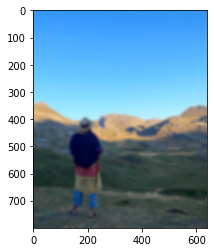

In [42]:
# blur 함수를 이용하여 사진 전체를 흐리게 처리
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

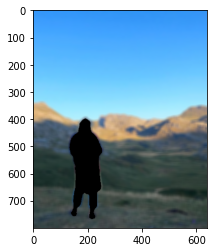

In [43]:
# 흐려진 사진에서 세그멘테이션 마스크를 분리해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()     # 배경은 255, 사람은 0

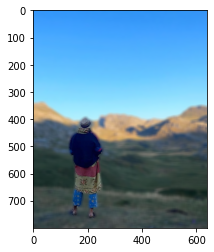

In [44]:
# 배경과 사람 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 최종 결과
* 앞선 사진들에 비해 배경과 사람을 잘 구분하여 모델이 아웃포커싱을 제대로 구현하는 것을 확인할 수 있음.

## 마치며
* 세 가지 다 다른 상황에서 세그멘테이션 모델이 잘 구현된 순서는 3 > 2 > 1
* 이는 모델이 사람을 인식할 때 외부에서 사람과 물체가 겹치지 않으면서, 동시에 사람과 배경만 있을 때 인식하는 정도가 높은 것을 알 수 있음.
* 따라서, 최대한 사람과 물체가 같이 있더라도 모델이 잘 인식할 수 있게 겹쳐 있지 않고, 사람과 배경을 잘 구분할 수 있는 외부에서 물체를 최대한 줄이는 사진일 때 세그멘테이션 모델이 잘 구현된다는 것을 깨달음.